In [1]:
# user defined R installation
import os
os.environ['R_HOME'] = 'D:/Program Files/R-4.5.0' #path to your R installation
%load_ext autoreload
%autoreload 2



import numpy as np
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import globalenv
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector

import sys
sys.path.append('../')
from causaloptim_py.causaloptim_python import run_experiment, extract_prob_dict
from binaryIV import simulate_deterministic_data_with_probabilistic_ate

from entropy_bounds.utils import entropy_dist

import matplotlib.pyplot as plt
import seaborn as sns
import math




# Load R packages
#igraph = importr('igraph')
causaloptim = importr('causaloptim')
base = importr('base')

In [50]:


results = []

for b_X_Y in np.arange(-5, 5, 0.005):  # Use np.arange for 0.5 steps
    sim = simulate_deterministic_data_with_probabilistic_ate(
        b_X_Y= b_X_Y
    )

    df = pd.DataFrame({'Y': sim['Y'], 'X': sim['X'], 'Z': sim['Z']})
    prob_dict = extract_prob_dict(df)

    graph_str = "(Z -+ X, X -+ Y, Ur -+ X, Ur -+ Y)"
    leftside = [1, 0, 0, 0]
    latent = [0, 0, 0, 1]
    nvals = [2, 2, 2, 2]
    rlconnect = [0, 0, 0, 0]
    monotone = [0, 0, 0, 0]

    bounds = run_experiment(graph_str, leftside, latent, nvals, rlconnect, monotone, prob_dict)
    bound_lower = float(bounds[0][0])
    bound_upper = float(bounds[1][0])
    bounds_valid = bound_lower <= sim['ATE_true'] <= bound_upper



    results.append({
        'b_X_Y': b_X_Y,
        'b_Z': sim['b_Z'],
        'b_U_X': sim['b_U_X'],
        'b_U_Y': sim['b_U_Y'],
        'entropy_Y': entropy_dist(sim['Y']),
        'entropy_Z': entropy_dist(sim['Z']),
        'entropy_U': entropy_dist(sim['U']),
        'corr_X_Y': np.corrcoef(sim['X'], sim['Y'])[0, 1],
        'corr_X_Z': np.corrcoef(sim['X'], sim['Z'])[0, 1],
        'corr_Y_Z': np.corrcoef(sim['Y'], sim['Z'])[0, 1],
        'ATE_true': sim['ATE_true'],
        'bound_lower': bound_lower,
        'bound_upper': bound_upper,
        'bound_width': bound_upper - bound_lower,
        'bounds_valid': bounds_valid
    })

df_results = pd.DataFrame(results)

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In boundsfunc(p00_0 = p00_0, p00_1 = p00_1, p10_0 = p10_0, p10_1 = p10_1,  :
R[write to console]: 
 
R[write to console]:  Invalid bounds! Data probably does not satisfy the assumptions in the DAG!



In [63]:
df_results = pd.DataFrame(results)
# calculate Dataframe in the interval b_X_Y = [-4, 4]
#df_results = df_results[(df_results['b_X_Y'] >= -5) & (df_results['b_X_Y'] <= 5)]
df_results

,b_X_Y,b_Z,b_U_X,b_U_Y,entropy_Y,entropy_Z,entropy_U,corr_X_Y,corr_X_Z,corr_Y_Z,ATE_true,bound_lower,bound_upper,bound_width,bounds_valid
0,-5.000,-1.040288,-0.566765,0.085715,-0.0,-0.0,-0.0,-0.450583,-0.171378,0.099955,-0.504092,-0.591134,0.190242,0.781377,True
1,-4.995,0.948241,-0.333257,0.701108,-0.0,-0.0,-0.0,-0.668264,0.162304,-0.085320,-0.566035,-0.783465,-0.037226,0.746239,True
2,-4.990,-0.809116,0.578659,0.201053,-0.0,-0.0,-0.0,-0.599392,-0.167837,0.082440,-0.517444,-0.714222,0.034114,0.748336,True
3,-4.985,-1.040191,-0.385196,1.598097,-0.0,-0.0,-0.0,-0.634031,-0.245292,0.153278,-0.651019,-0.748860,-0.049300,0.699560,True
4,-4.980,0.702640,0.241142,-0.337419,-0.0,-0.0,-0.0,-0.606303,0.172340,-0.118115,-0.451711,-0.768939,-0.018554,0.750385,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,4.975,-0.943808,0.755188,-1.108233,-0.0,-0.0,-0.0,0.596384,-0.224849,-0.129247,0.612221,0.023910,0.707573,0.683663,True
1996,4.980,-1.564263,-0.456588,0.146035,-0.0,-0.0,-0.0,0.503154,-0.359133,-0.124781,0.473920,0.109564,0.560976,0.451412,True
1997,4.985,0.338001,-0.533919,0.017199,-0.0,-0.0,-0.0,0.509984,0.110919,0.083761,0.491014,-0.168980,0.684601,0.853581,True
1998,4.990,-0.897981,-0.536193,-1.409412,-0.0,-0.0,-0.0,0.636601,-0.140865,-0.072307,0.630371,-0.062031,0.752486,0.814517,True


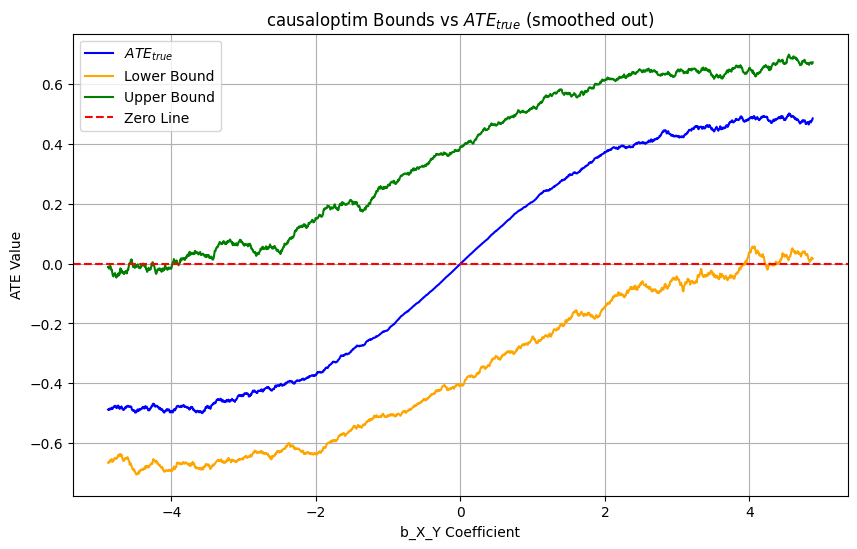

In [99]:
# Smoothen the data using a rolling average
df_results['ATE_true_smooth'] = df_results['ATE_true'].rolling(window=50, center=True).mean()
df_results['bound_lower_smooth'] = df_results['bound_lower'].rolling(window=50, center=True).mean()
df_results['bound_upper_smooth'] = df_results['bound_upper'].rolling(window=50, center=True).mean()

# Plot the smoothed data
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_results, x='b_X_Y', y='ATE_true_smooth', label='$ATE_{true}$', color='blue')
sns.lineplot(data=df_results, x='b_X_Y', y='bound_lower_smooth', label='Lower Bound', color='orange')
sns.lineplot(data=df_results, x='b_X_Y', y='bound_upper_smooth', label='Upper Bound', color='green')
plt.axhline(0, color='red', linestyle='--', label='Zero Line')
plt.title('causaloptim Bounds vs $ATE_{true}$ (smoothed out)')
plt.xlabel('b_X_Y Coefficient')
plt.ylabel('ATE Value')
plt.legend()
plt.grid(True)
plt.show()


In [54]:
### Average bound width 
# Calculate the average bound width
average_bound_width = df_results['bound_width'].mean()
print(f"Average Bound Width: {average_bound_width}")
# average bound width with b_X_Y in [-4, 4]
average_bound_width_b_X_Y = df_results[(df_results['b_X_Y'] >= -4) & (df_results['b_X_Y'] <= 4)]['bound_width'].mean()
print(f"Average Bound Width (b_X_Y in [-4, 4]): {average_bound_width_b_X_Y}")

Average Bound Width: 0.722537198441364
Average Bound Width (b_X_Y in [-4, 4]): 0.7407738283039792


In [104]:
# Perform OLS regression using statsmodels
import statsmodels.api as sm
valid_df = df_results[df_results['bounds_valid'] == True]
# Add a constant for the intercept
valid_df['corr_X_Y_squared'] = valid_df['corr_X_Y'] ** 2
valid_df['corr_X_Z_squared'] = valid_df['corr_X_Z'] ** 2
X = sm.add_constant(valid_df[['corr_X_Y', 'corr_X_Y_squared', 'corr_X_Z', 'corr_X_Z_squared']])	
y = valid_df['bound_width']

# Fit the OLS model
ols_model = sm.OLS(y, X).fit()

# Print the summary
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:            bound_width   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     1885.
Date:                Tue, 22 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:54:52   Log-Likelihood:                 2449.5
No. Observations:                1994   AIC:                            -4889.
Df Residuals:                    1989   BIC:                            -4861.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.9244      0.003  

C:\Users\tmari\AppData\Local\Temp\ipykernel_14548\1614531955.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['corr_X_Y_squared'] = valid_df['corr_X_Y'] ** 2
C:\Users\tmari\AppData\Local\Temp\ipykernel_14548\1614531955.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['corr_X_Z_squared'] = valid_df['corr_X_Z'] ** 2


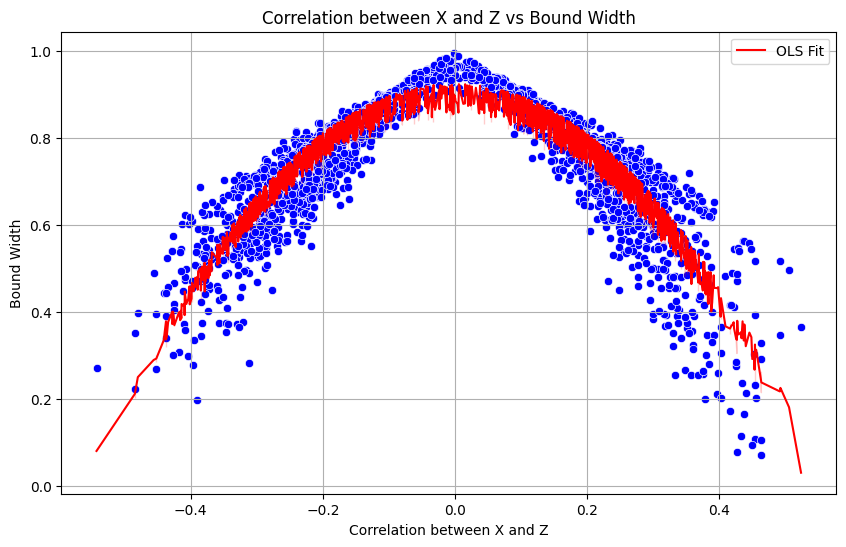

In [ ]:
### Plot corr_X_Z vs bound_width (smoothed)
valid_df['ols_fit_smooth_corr_X_Z'] = pd.Series(ols_model.predict(X)).rolling(window=100, center=True).mean()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=valid_df, x='corr_X_Z', y='bound_width', color='blue', alpha=0.6, label='Original Data')
sns.lineplot(data=valid_df, x='corr_X_Z', y='ols_fit_smooth_corr_X_Z', color='red', label='Smoothed OLS Fit')
plt.title('Correlation between X and Z vs Bound Width (Smoothed)')
plt.xlabel('Correlation between X and Z')
plt.ylabel('Bound Width')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\tmari\AppData\Local\Temp\ipykernel_14548\2420919186.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['bound_width_smooth'] = valid_df['bound_width'].rolling(window=100, center=True).mean()
C:\Users\tmari\AppData\Local\Temp\ipykernel_14548\2420919186.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['ols_fit_smooth'] = pd.Series(ols_model.predict(X)).rolling(window=100, center=True).mean()


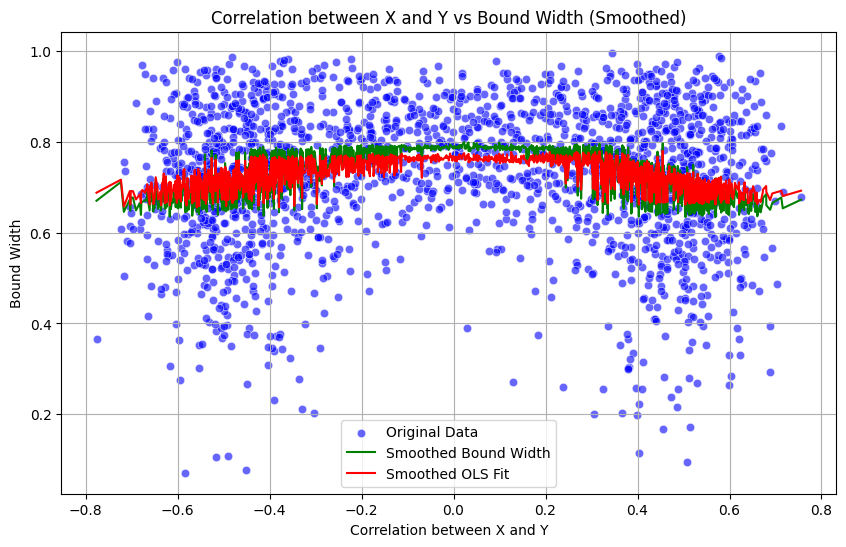

In [92]:
### Plot corr_X_Y vs bound_width (smoothed)
valid_df['bound_width_smooth'] = valid_df['bound_width'].rolling(window=100, center=True).mean()
valid_df['ols_fit_smooth'] = pd.Series(ols_model.predict(X)).rolling(window=100, center=True).mean()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=valid_df, x='corr_X_Y', y='bound_width', color='blue', alpha=0.6, label='Original Data')
sns.lineplot(data=valid_df, x='corr_X_Y', y='bound_width_smooth', color='green', label='Smoothed Bound Width')
sns.lineplot(data=valid_df, x='corr_X_Y', y='ols_fit_smooth', color='red', label='Smoothed OLS Fit')
plt.title('Correlation between X and Y vs Bound Width (Smoothed)')
plt.xlabel('Correlation between X and Y')
plt.ylabel('Bound Width')
plt.legend()
plt.grid(True)
plt.show()

In [101]:
df_invalid = df_results[df_results['bounds_valid'] == False]

df_invalid

,b_X_Y,b_Z,b_U_X,b_U_Y,entropy_Y,entropy_Z,entropy_U,corr_X_Y,corr_X_Z,corr_Y_Z,ATE_true,bound_lower,bound_upper,bound_width,bounds_valid,ATE_true_smooth,bound_lower_smooth,bound_upper_smooth,bound_width_smooth
173,-4.135,-1.736569,0.577525,-0.191313,-0.0,-0.0,-0.0,-0.461367,-0.378784,0.041455,-0.462841,-0.373971,-0.178268,0.195703,False,-0.487903,-0.683485,-0.027314,0.656171
503,-2.485,-1.410730,0.173914,-1.867159,-0.0,-0.0,-0.0,-0.293124,-0.406763,0.124714,-0.274535,-0.251061,-0.033162,0.217899,False,-0.401809,-0.625986,0.034398,0.660383
1642,3.210,-1.918032,0.873236,0.252237,-0.0,-0.0,-0.0,0.408309,-0.418534,-0.104116,0.433821,0.152308,0.383541,0.231232,False,0.450215,-0.060318,0.649128,0.709446
1832,4.160,1.828598,-1.006221,0.915293,-0.0,-0.0,-0.0,0.394683,0.387589,0.158675,0.382990,0.226320,0.334267,0.107947,False,0.489725,0.027407,0.647187,0.619780
1878,4.390,2.222435,-1.432231,1.373166,-0.0,-0.0,-0.0,0.376611,0.523391,0.220044,0.346252,0.371989,0.131893,-0.240096,False,0.485821,0.003264,0.675194,0.671930
1957,4.785,1.756828,-1.449276,0.805597,-0.0,-0.0,-0.0,0.469066,0.409095,0.154402,0.396920,0.243898,0.381511,0.137613,False,0.471907,0.031416,0.670758,0.639342
